In [ ]:
! pip install -q huggingface_hub
! pip install -q -U datasets

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from pathlib import Path

# http://participants-area.bioasq.org/datasets/
# training: http://participants-area.bioasq.org/Tasks/10b/trainingDataset/
# test: http://participants-area.bioasq.org/Tasks/10b/goldenDataset/
path = Path("/kaggle/input/bioasq10b")

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict
import json

In [7]:
def process_data(file):
    data = json.load(file)
    df = pd.json_normalize(data["questions"])
    df = df[df["type"] == "factoid"]
    df = df.reset_index(drop=True)
    df = df[["id", "body", "ideal_answer", "exact_answer", "snippets"]]
    df.columns = ["id", "question", "long_answer", "answer", "context"]

    df["long_answer"] = df.long_answer.apply(lambda x: x[0])
    df["answer"] = df.answer.apply(lambda x: x[0])
    df["context"] = df.context.apply(
        lambda x: " ".join([context["text"] for context in x])
    )
    return df

In [8]:
file = open(path / "training10b.json")
train_df = process_data(file)

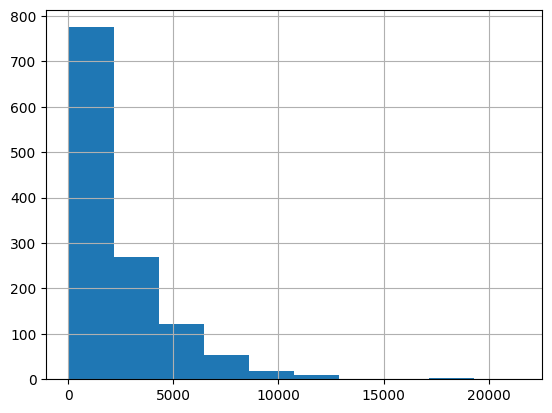

In [9]:
train_df["length"] = train_df.context.apply(lambda x: len(x))
train_df["length"].hist()
train_df = train_df.drop("length", axis=1)

In [10]:
hf_dataset = DatasetDict({"train": Dataset.from_pandas(train_df), "test": []})

In [26]:
df_list = []
for i in range(1, 7):
    filename = f"10B{i}_golden.json"
    file = open(path / filename)
    df = process_data(file)
    df["answer"] = df.answer.apply(lambda x: x[0])
    df_list.append(df)

test_df = pd.concat(df_list)
test_df = test_df.reset_index(drop=True)

hf_dataset["test"] = Dataset.from_pandas(test_df)

In [ ]:
hf_dataset.push_to_hub("bioasq10b")